# Spatial Dataset Pre-Processing (Single AP Slice Only)
Script that converts a pre-processed AnnData object from STARmap/SPARTseq to a Vitessce-compatible Zarr file format. 

**Input:** AnnData Object for Spatial Data 

**Output:** Zarr File 

### Load Packages

In [2]:
import anndata as ad 
import scanpy as sc
import numpy as np
import pandas as pd 
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os

from vitessce import (
    VitessceConfig,
    Component as cm,
    CoordinationType as ct,
    AnnDataWrapper,
)
from vitessce.data_utils import (
    optimize_adata,
    VAR_CHUNK_SIZE,
)

warnings.simplefilter(action="ignore", category=Warning)

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

print("All packages loaded successfully!")

All packages loaded successfully!


### Set Directory 
Modify the `path` below to your directory that includes the dataset (AnnData).  

In [3]:
# change the directory to general to access data 
path = "/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/"
os.chdir(path)
# verify the change
print("New working directory:", os.getcwd())

New working directory: /Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris


### Check versions 

In [4]:
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.24.4 scipy==1.9.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 pynndescent==0.5.13


### Load processed STARmap dataset

In [5]:
data = ad.read_h5ad("vitessce-cerebellum/data/e11_cell_types_4-13-25.h5ad")

In [6]:
# see dimensions of dataset
data 

AnnData object with n_obs × n_vars = 25341 × 1742
    obs: 'cell_number', 'library_id', 'timepoint', 'batch', 'n_genes_by_counts', 'total_counts', 'n_counts', 'leiden', 'cell_types', 'finer_cell_types'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_types_colors', 'finer_cell_types_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial', 'spatial3d'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
e11_1 = data[data.obs["library_id"] == "e11_1", :]

Normalizing for Vitessce: 

Normalize into same square scale 0-1000 for Vitessce, while preserving the original spatial relationships between points. 

In [9]:
# Get original spatial
spatial = e11_1.obsm["spatial"]
x = spatial[:, 0]
y = spatial[:, 1]

# Get min and max
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# Determine aspect-ratio-preserving scaling
x_range = x_max - x_min
y_range = y_max - y_min
max_range = max(x_range, y_range)

# Scale both to [0, 1000] while preserving relative position
x_scaled = (x - x_min) / max_range * 1000
y_scaled = (y - y_min) / max_range * 1000

# Store back
e11_1.obsm["spatial"] = np.vstack([x_scaled, y_scaled]).T


In [10]:
# view shape of x and y spatial coordinates in our dataset after scaling
pd.DataFrame(e11_1.obsm["spatial"], columns=["x", "y"]).describe()

,x,y
count,6033.000000,6033.000000
mean,520.143475,97.182519
std,306.452411,54.870137
min,0.000000,0.000000
25%,242.796711,58.024355
50%,615.694479,92.289257
75%,810.858533,129.859903
max,1000.000000,260.456838


In [43]:
e11_1.obsm['spatial'] = e11_1.obsm['spatial'].astype('uint16') # ensure that the spatial coordinates have a JavaScript-compatible integer data type

[<Axes: title={'center': 'Rora'}, xlabel='spatial1', ylabel='spatial2'>]

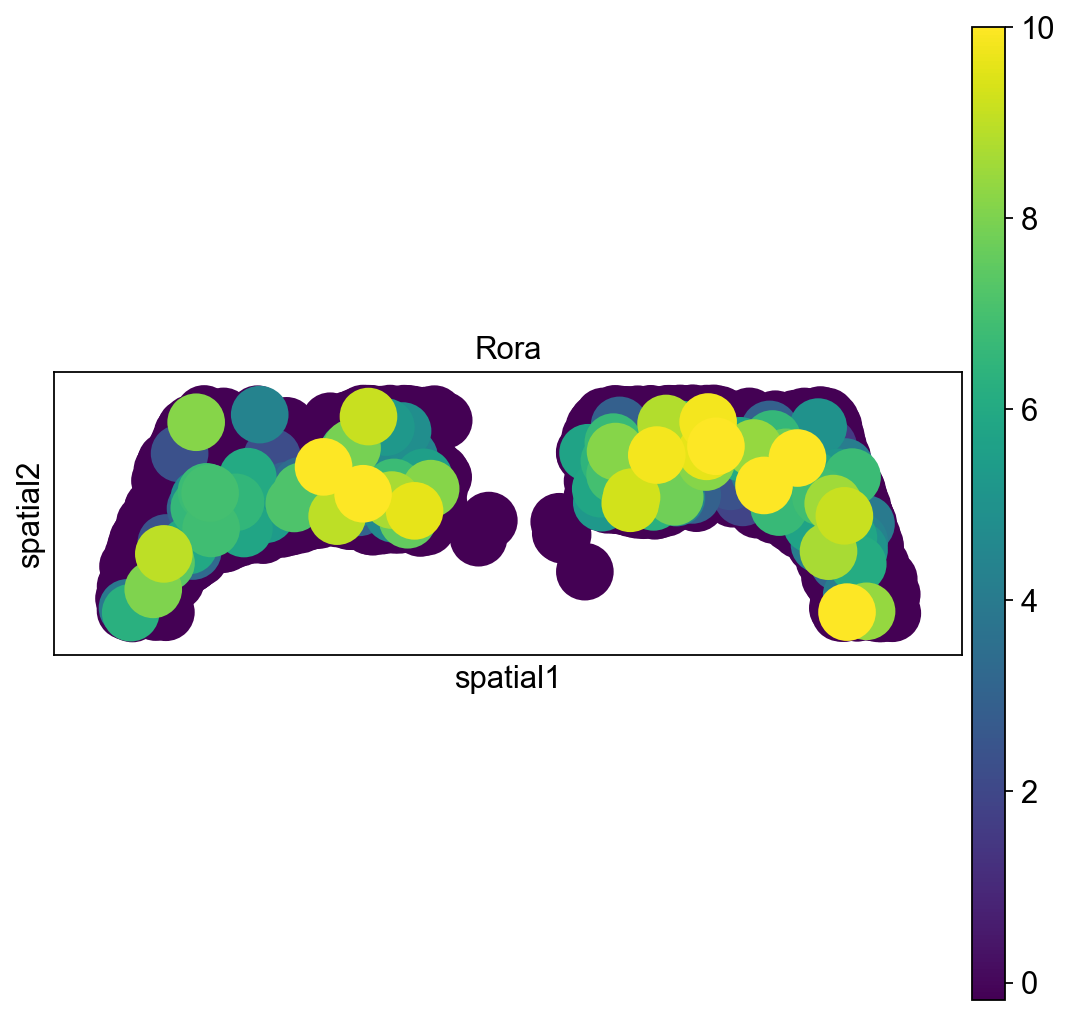

In [11]:
# visualize dataset spatially 
sc.pl.spatial(e11_1, spot_size=75, color="Rora", show=False) 

Save processed data to a Zarr format. 

In [12]:
# change the directory to general to access data 
path = "/Users/iriskwon/Desktop/mouse-cereb-dev/mouse-cereb-dev"
os.chdir(path)

# verify the change
print("New working directory:", os.getcwd())

New working directory: /Users/iriskwon/Desktop/mouse-cereb-dev/mouse-cereb-dev


Subsetting only E11 

In [13]:
e11_1.write_zarr("public/data/E11_1.zarr")